# NMFM3311 - Final Project
## Viktor Procházka
------
## Problem 1 - Implement NPV and IRR functions

Task: 
>Define two functions that compute the net present value (NPV) and the internal
rate of return (IRR). Similar functions are already implemented in the numpy library,
but your implementation should compute it directly and use the existing functions
only as a check for the correctness. The function NPV should be a function of (rate,
cash flow), the IRR should be a function of a (cash flow). Show that your functions replicate the numbers from numpy documentation, namely
>>`np.npv(0.281, [-100, 39, 59, 55, 20])` = -0.00847859163845488
>>
>>`np.irr([-100, 39, 59, 55, 20])` = 0.28094842115996066

### NPV calculation
Net present value is defined as follows
$$ \text{NPV}= \sum_{t = 0}^n \frac{R_t}{(1+i)^t}  $$
where $R_t$ is cashflow at time $t$ and $i$ is the discount rate.

Calculation of the NPV is straightforward as all we need to do is to evaluate the polynomial given by the definition. To do this calculation in $O(n)$ we can use Horner's method for polynomial evaluation. We can also calculate the NPV as given by its definition.

In [1]:
import numpy as np
from numpy.random import normal
from math import ceil
from matplotlib import pyplot as plt
import scipy.stats as stat
from matplotlib.ticker import PercentFormatter
from cvxopt import matrix, solvers
import pandas as pd
from pandas_datareader import data
import time
np.random.seed(1) #seed for debugging

In [2]:
def NPV(discount_factor, cashflow_list):
    """Calculates the NPV for given discount factor and list of cashflow using Horner's method"""
    
    npv_value = 0
    discount_quotient = 1/(1+discount_factor)
    
    for i in range(len(cashflow_list)):
        npv_value = npv_value * discount_quotient
        npv_value += cashflow_list[-i-1]
        
    return npv_value

def NPV_vectorized(discount_factor, cashflow_list):
    """Calculates the NPV for given discount factor and list of cashflow 
    by first evaluating polynomial factors and then adding them up """
    
    npv_factor = lambda i, r, t : r*1/(1+i)**t
    discount_vector = [discount_factor for x in cashflow_list]
    return sum(map(npv_factor, discount_vector, cashflow_list, range(len(cashflow_list))))

print(f'NPV to be calculated:      -0.00847859163845488')
print(f'Calculated NPV - Horner:   {NPV(0.281,[-100, 39, 59, 55, 20])}')
print(f'Calculated NPV - standard: {NPV_vectorized(0.281,[-100, 39, 59, 55, 20])}')

NPV to be calculated:      -0.00847859163845488
Calculated NPV - Horner:   -0.00847859163846465
Calculated NPV - standard: -0.00847859163845488


We see that the first implementation returns a sufficiently close number while the second returns the exact same number.

### IRR calculation

Internal rate of return is defined by the following property
$$ \sum_{t = 0}^n \frac{R_t}{(1+\text{IRR})^t} = 0 $$
where $\text{IRR}$ is the internal rate of return.

Calculation of the IRR is not so easy, since it requires us to solve a polynomial equation. To solve this equation, we will use python's numerical library numpy with its integrated numerical polynomial equation solver.

In [3]:
from numpy import roots as polynomial_solver

def IRR(cashflow_list):
    """Calculates the NPV for given list of cashflow """
    """We first solve a polynomial equation and from all its solutions we select the real and nonnegative solution"""
    
    possible_solutions = polynomial_solver(cashflow_list)
    solution = [np.real(x-1) for x in possible_solutions if (np.isreal(x)) and (np.real(x) > 0)][0]
    return solution
    

print(f'IRR to be calculated: 0.28094842115996066')
print(f'Calculated IRR:       {IRR([-100, 39, 59, 55, 20])}')

IRR to be calculated: 0.28094842115996066
Calculated IRR:       0.280948421159962


The number calculated by us lies sufficiently close to the number which was to be calculated.

## Problem 2 - Monte Carlo Simulation of Asset Prices
Problem:

>Assume that the log returns of the asset price are independent and normally distributed with $\mathcal{N}\left(0,\,\sigma \sqrt{dt}\right)$ distribution. Before the simulation, fix three parameters:
>
>>$\sigma$ the volatility of the asset <br/>
>>$T$ the sampling horizon <br/>
>>$n$ the number of sampling points
>
>Make reasonable choices for these parameters. Let the increment $dt$ be $\frac{T}{n}$.

### Daily log returns
Task:

>Write a procedure that simulates $n$ log increments with distribution $\mathcal{N}\left(0,\,\sigma \sqrt{dt}\right)$. Store them in a single object and plot them on a corresponding time horizon $[0, \,T]$ 

We begin by setting the constants and generating the log-return data, which is normaly distributed. After consideration of data in task 4, which deals with real trading data, we will set $\sigma$ equal to 0.3. The choice of $T$ is somewhat arbitrary, let us set it to 3 years. We will set $n$ to be equal to 3\*253, as there are averagely 253 trading days on NYSE every year.

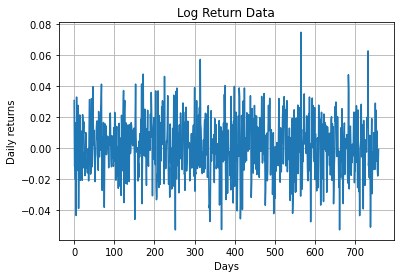

In [4]:
task2_sigma = 0.3
task2_T = 3 #years
task2_n = task2_T*253

task2_dt = task2_T/task2_n
log_return = normal(0, task2_sigma*np.sqrt(task2_dt), task2_n)


fig, ax = plt.subplots()
ax.plot(log_return)

ax.set_title('Log Return Data')
ax.set(xlabel = 'Days', ylabel = 'Daily returns')
ax.grid()

### Cumulative log returns
Task: 

>Take cumulative log returns and store them in an object `cm_log_return`. Plot this in a separate graph.

We will take the cumulative sum of previously generated data and plot it.

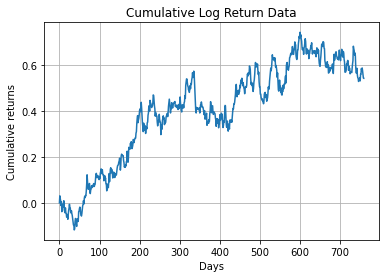

In [5]:
cm_log_return = np.append(0, np.cumsum(log_return))

fig, ax = plt.subplots()
ax.plot(cm_log_return)
ax.set_title('Cumulative Log Return Data')
ax.set(xlabel = 'Days', ylabel = 'Cumulative returns')
ax.grid()

### Asset price evolution
Task:

>An instance of a simulated asset price should be an exponentiated cumulative
log return. More precisely, <br/>
$S(t) = S(0) \cdot exp\Big($ `cm_log_return[t]` $-\frac{1}{2}\sigma^2t\Big)$ <br/>
Plot it on a separete graph

We will use the given function on previously obtained data.

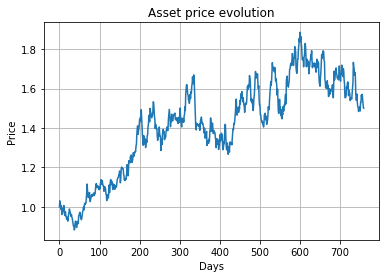

In [6]:
time = np.arange(0, task2_T + task2_dt, task2_dt)
S = np.zeros(task2_n + 1)
S[0] = 1
S = S[0]*np.exp(cm_log_return - 0.5*task2_sigma**2*time)

fig, ax = plt.subplots()
ax.plot(S)
ax.set_title('Asset price evolution')
ax.set(xlabel = 'Days', ylabel = 'Price')
ax.grid()

### Multiple asset price simulations
Task:

>Generate 20 scenarios of this price evolution and plot them on a single graph.

We will encapsulate previous calculations in a function for later use. Then we shall call this 20 times and plot the simulated prices.

In [7]:
def asset_price_simulation(sigma, T, n, face_value = 1, E = 0):    
    """Generates an instance of simulated asset price"""
    S = np.zeros(n+1)
    S[0] = face_value

    dt = T/n
    time = np.arange(0, T + dt, dt)
    log_return = normal(E, sigma*np.sqrt(dt), n) 
    cm_log_return = np.append(0, np.cumsum(log_return))
    S = S[0]*np.exp(cm_log_return - 0.5*sigma**2*time)

    values = S.tolist()
    return values

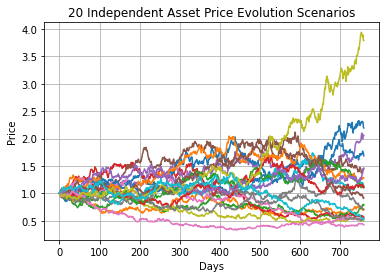

In [8]:
fix, ax = plt.subplots()

for i in range(20):
    s = asset_price_simulation(task2_sigma, task2_T, task2_n)
    ax.plot(s)
    
ax.set_title('20 Independent Asset Price Evolution Scenarios')
ax.set(xlabel = 'Days', ylabel = 'Price');
ax.grid()

## Problem 3 - Monte Carlo Simulation for Valuation

Problem:

>Consider the following financial contract. The time horizon is T = 3 years and
there are n = 6 semiannual monitoring points. The contract has a face value 100.
The client receives 2.5% coupon when the monitoring price is above 80% of the
initial price of the underlying asset. This coupon is also received retroactively for all
monitoring points that were below 80% before any observed value above 80%. Thus
the number of 2.5% coupons received is in fact the index of the last observed value
above 80%. Moreover, if the price of the underlying security is above 100% at the
monitoring point, the contract is terminated (the coupons are paid). In addition,
if the price of the underlying asset is above 60% at the expiration time T = 3,
the client receives the face value 100 in full, otherwise she will receive the value
corresponding to the percentage of the final value of the underlying asset.

### Contract simulation

Task:

>Write the simulation procedure that computes the realized payoff for a single
asset evolution scenario.

We will use a previously defined function to get the monitoring price data and define a function that returns cashflows for the generated data using this contract's conditions.

In [9]:
def coupon_count(bound, values):
    """Determines the last index with value over bound"""
    for i in range(len(values)-1, -1, -1):
        if values[i] >= bound:
            return i
    return 0


def find_first_index_over(bound, values):
    """Determines the first index with value over bound"""
    for i in range(len(values)):
        if values[i] > bound:
            return i+1 
    return len(values) 


def contract_payoff(sigma, plot = False):
    """Realizes a single payoff of contract from problem 3"""
    coupon = 2.5
    values = asset_price_simulation(sigma, 3, 6, 100)
    values = values[:find_first_index_over(100, values)]
    number_of_coupons = coupon_count(80, values)
    
    if plot:
        fig, ax = plt.subplots()
        ax.set_title('Underlying asset values')
        ax.set(xlabel = 'Monitoring points', ylabel = 'Asset price')
        ax.plot(values)
        sixty_line = [60 for val in values]
        eighty_line = [80 for val in values]
        hundred_line = [100 for val in values]
        x = list(range(len(values)))
        ax.plot(sixty_line, linestyle = '--', color = 'C5')
        ax.plot(eighty_line , linestyle = '--', color = 'C5')
        ax.plot(hundred_line , linestyle = '--', color = 'C5')
        for i in range(len(values)):
            ax.axvline(x=i, linestyle = ':', color = 'C5')

    if values[-1] > 60:
        return 100 + number_of_coupons*coupon
    else:
        return values[-1] + number_of_coupons*coupon
    


115.0

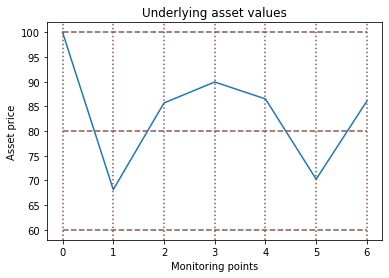

In [10]:
np.random.seed(321351654) #this seed creates a nice example
contract_payoff(0.3, plot = True)

### Expected payoff confidance interval
Task:

>Generate sufficiently many scenarios that estimate the expected payoff of this
contract using the average payoff. Note the standard deviation of this result and
give 95% confidence interval of the expected payoff. Use some reasonable choices of
sigma (like 0.2 or 0.3). Try to find the value sigma for which the fair value of the
contract is at par.

To estimate the expected payoff, we will use the mean estimator. For the construction of the confidence interval, we will use the following relation

$$ \sqrt{n} \; \frac{\overline{X}_n - \mu_X}{S_n}  \stackrel{as.}{\sim} \mathcal{N}(0, 1)$$

which yields the following confidance interval
$$ \mathbb{P}\left(\overline{X}_n -u_{1-\alpha /2}\frac{S_n }{\sqrt{n}} \leq \mu_X \leq \overline{X}_n +u_{1-\alpha/2}\frac{S_n }{\sqrt{n}} \right) = 1-\alpha$$

where $u_{1-\alpha/2}$ marks the $\left(1-\frac{\alpha}{2}\right)$-th quantile of $\mathcal{N}(0, 1)$ distribution. To estimate how many scenarios are sufficiently many, will will find $n$ sufficiently large that

$$u_{1-\alpha /2}\frac{S_n}{\sqrt{n}} \leq \frac{\epsilon}{2}$$

for $\epsilon$ sufficiently small according to the application. This ensures a narrow confidence interval. The smallest $n$ fullfilling this condition is the following value 

$$n = \left\lceil \left( \frac{2u_{1-\alpha /2}S_n}{\epsilon} \right)^2 \right\rceil$$

For our application, setting $\epsilon$ equal 0.1 should suffice. To estimate $n$, we must first estimate $\sigma(X)$.

In [11]:
task4_sigma = 0.2291
n = 500000
print('This estimate takes roughly {:.2f} seconds'.format(2*n/(100000)))
      
data = [contract_payoff(task4_sigma) for x in range(n)]
stdev = np.std(data, ddof = 1)
print('Estimated standard deviation: {:.4f}'.format(stdev))

This estimate takes roughly 10.00 seconds
Estimated standard deviation: 16.6610


In [12]:
def t_statistic_mean_confidence_interval(stdev, alpha, epsilon, sigma):
    """Returns a confidence interval for mean using t-statistic"""
   
    left_t_bound, right_t_bound = stat.norm.interval(1-alpha)

    n = ceil((2*right_t_bound*stdev/epsilon)**2)
    print('Sufficiently large n: {:,}'.format(n))
    print('Generating data will take roughly {:.2f} seconds'.format(2*n/(100000)))
    data = [contract_payoff(sigma) for x in range(n)]
    mean = np.mean(data)
    return (mean - right_t_bound*stdev/np.sqrt(n), mean-left_t_bound*stdev/np.sqrt(n))

In [13]:
alpha = 0.05
epsilon = 0.1

L, R = t_statistic_mean_confidence_interval(stdev, alpha, epsilon, task4_sigma)

print('Sigma:                      {:.4f}'.format(task4_sigma))
print('Expected payoff:            {:.2f}'.format((L+R)/2))
print('Payoff standard deviation:  {:.3f}'.format(stdev))
print('Mean standard deviation:    {:.4f}'.format(stdev/n))
print('Alpha:                      {:.2f}'.format(alpha))
print('Confidance interval:       ({:.4f}, {:.4f})'.format(L, R))

Sufficiently large n: 426,540
Generating data will take roughly 8.53 seconds
Sigma:                      0.2291
Expected payoff:            99.99
Payoff standard deviation:  16.661
Mean standard deviation:    0.0000
Alpha:                      0.05
Confidance interval:       (99.9373, 100.0373)


We can see that setting $\sigma$ slightly lower than 0.23 creates data with mean close to 100 and confidance interval for the mean which contains the value 100. Therefore, it can be said that for the contract to be fair, the value of $\sigma$ should be around 0.23.

### Expected payoff histogram
Task:

>Plot the histogram of the payoff distribution for sigma 0.2 and 0.3.

We will generate many possible payoff scenarios with various values of $\sigma$ and construct histograms using this data.

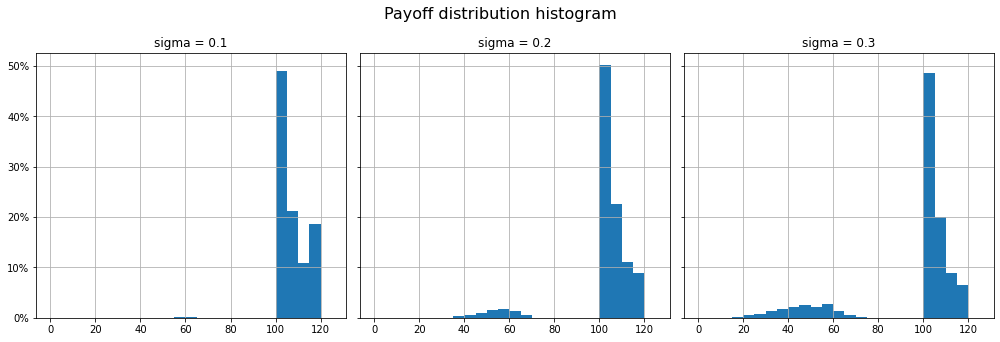

In [14]:
n = 10000 #number of simulated contracts for each sigma
task4_sigma_list = [0.1, 0.2, 0.3] #arbitrarily long list of sigmas for comparison

data = [[contract_payoff(sigma_val) for x in range(n)] for sigma_val in task4_sigma_list]


fig, ax = plt.subplots(1, len(data), figsize=(14, 4.8), sharey=True, tight_layout=True)
fig.suptitle('Payoff distribution histogram', fontsize=16)

for i in range(len(data)):
    ax[i].hist(data[i], [x for x in range(130) if x%5 == 0],  weights=np.ones(len(data[i]))/len(data[i]))
    ax[i].grid(True)
    ax[i].set_title("sigma = {}".format(task4_sigma_list[i]))

fig.gca().yaxis.set_major_formatter(PercentFormatter(1))

## Problem 4 - Optimal portfolio

Problem:

>The goal of this problem is to find the optimal portfolio weights for 10 randomly
chosen assets from SP500. First, download the table of components of SP500. Generate 10 SP500 components using your student ID and load the price data starting from 2019-01-01. Remove any component that was added to the index after 2019-01-01.

### Loading and preparing the data

Task:

>Compute the daily log returns of the prices and use these values to estimate the
annualized mean returns $\mu$ and the annualized covariance matrix $\Sigma$ using the sample
mean and sample covariances. Make sure that the resulting covariance matrix is
positive definite.

First, we will download the data and compute daily log returns. We will calculate the mean and covariance matrix. Because after the aplication of logarithm time becomes additve, we can simply calculate expexted annual return and annual covariance matrix by multiplying the mean daily log return by $253$ and the daily log return standard deviation by $\sqrt{253}$.

In [15]:
#this cell was copied from the task

import numpy as np
import pandas as pd
from pandas_datareader import data
import time

np.random.seed(92943209)

table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
all_tickers = table['Symbol'].tolist()


all_tickers = [ticker.replace('.', '-') for ticker in all_tickers]

tickers = np.random.choice(all_tickers, 10, replace = False)

start_date = '2019-01-01'
end_date = time.strftime("%Y-%m-%d")
sp500 = data.DataReader(tickers, 'yahoo', start_date, end_date)['Adj Close'] #this one takes a while...


In [16]:
sp500.columns.name = 'Tickers'
date = sp500['HPE'].index[0]
sigma =sp500.pct_change().apply(lambda x: np.log(1+x)).cov().to_numpy()
cov_matrix = sp500.pct_change().apply(lambda x: np.log(1+x)).cov()

E = sp500.pct_change().apply(lambda x: np.log(1+x)).mean().to_numpy()
expected_return = sp500.pct_change().apply(lambda x: np.log(1+x)).mean()


print(f'Control starting date: {date}')
print('Tickers with different starting date: ', end = '')
print( [ ticker for ticker in tickers if sp500[ticker].index[0] != sp500['HPE'].index[0]])
print(f"Sigma positive definite check: {np.all(np.linalg.eigvals(cov_matrix) > 0)}")

Control starting date: 2019-01-02 00:00:00
Tickers with different starting date: []
Sigma positive definite check: True


In [17]:
print('Expected annual log return: ')
expected_return.apply(lambda x: 253*x)

Expected annual log return: 


Tickers
UDR     0.014749
LYV     0.206439
ALL     0.154036
SJM     0.132798
MPC    -0.159894
VRSN    0.189877
AES     0.271665
HPE    -0.035590
TPR    -0.056027
CMG     0.592605
dtype: float64

In [18]:
print('Annual log return covariance matrix: ')
cov_matrix.index.name = ''
cov_matrix.apply(lambda x: 253*x)

Annual log return covariance matrix: 


Tickers,UDR,LYV,ALL,SJM,MPC,VRSN,AES,HPE,TPR,CMG
,,,,,,,,,,
UDR,0.144689,0.118341,0.080563,0.024828,0.147742,0.054479,0.097036,0.087555,0.139224,0.045543
LYV,0.118341,0.305895,0.100380,0.007735,0.215618,0.067289,0.138129,0.131081,0.201346,0.099715
ALL,0.080563,0.100380,0.109046,0.029707,0.141536,0.062755,0.097109,0.080281,0.116250,0.059097
SJM,0.024828,0.007735,0.029707,0.076480,0.025366,0.031762,0.017146,0.021240,0.038185,0.006499
MPC,0.147742,0.215618,0.141536,0.025366,0.417751,0.081138,0.187947,0.186923,0.242643,0.090740
VRSN,0.054479,0.067289,0.062755,0.031762,0.081138,0.102418,0.066095,0.059559,0.091081,0.062896
AES,0.097036,0.138129,0.097109,0.017146,0.187947,0.066095,0.196630,0.107120,0.149930,0.087063
HPE,0.087555,0.131081,0.080281,0.021240,0.186923,0.059559,0.107120,0.195116,0.185913,0.053034
TPR,0.139224,0.201346,0.116250,0.038185,0.242643,0.091081,0.149930,0.185913,0.457687,0.065591


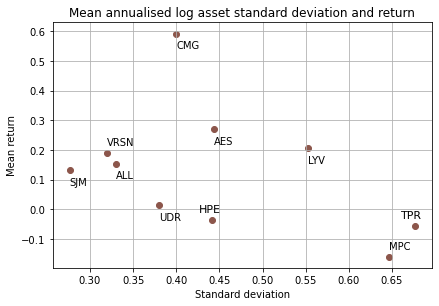

In [19]:
fig, ax = plt.subplots()
fig.tight_layout()
x = np.sqrt(np.diag(sigma))*np.sqrt(253)
y = E*253
ax.scatter(x, y, color = 'C5')

for i in range(len(tickers)):
    if tickers[i] not in ['VRSN', 'MPC', 'TPR', 'HPE']:
        ax.text(x[i], y[i]-0.0002*253, tickers[i], fontsize = 10)
    elif tickers[i] in ['VRSN', 'MPC']:
        ax.text(x[i], y[i]+0.0001*253, tickers[i], fontsize = 10)
    else:
        ax.text(x[i]-0.001*np.sqrt(253), y[i]+0.0001*253, tickers[i], fontsize = 11)
ax.set(xlabel = 'Standard deviation', ylabel = 'Mean return')
ax.grid()
ax.set_title("Mean annualised log asset standard deviation and return");

### Optimal portfolio class
This section defines the `PortfolioSet` and `OptimalPortfolio` classes, which are useful for code encapsulation and create easy-to-read code later on.

In [20]:
#In a civilised world this cell would be outsourced and imported as a separate classes... Doomsday is now.

class PortfolioSet:
    def __init__(self, b_w, frontier = True):
        """bounded weights and frontier are informative, affect plotting"""
        
        self.frontier = frontier
        self.bounded_weights = b_w
        self.expectations = []
        self.variances = []
        self.stdevs = []
        self.weights = []
        
        
    def load(self, exp, var, std, w):
        self.expectations = exp
        self.variances = var
        self.stdevs = std
        self.weights = w
        
        
    def plot(self, ax, scale = 253):
        if not self.frontier:
            ax.scatter(np.sqrt(scale)*self.stdevs, scale*self.expectations, color = 'C9', marker = '.')
            ax.set(xlabel = 'Standard deviation', ylabel = 'Mean log return')
        elif not self.bounded_weights:
            ax.plot(np.sqrt(scale)*self.stdevs, scale*self.expectations, color = 'C0')
            ax.set(xlabel = 'Standard deviation', ylabel = 'Mean log return')
        else:
            ax.plot(np.sqrt(scale)*self.stdevs, scale*self.expectations, color = 'C8')
            ax.set(xlabel = 'Standard deviation', ylabel = 'Mean log return')
        
        

class OptimalPortfolio:
    """Class used to compute optimal portfolio"""
    """Uses cvxopt.solvers and cvxopt.matrix"""
    
    def __init__(self, expectations, cov_matrix, tickers_list):
        from cvxopt import matrix, solvers
        
        solvers.options['show_progress'] = False
        
        self.sigma = cov_matrix
        self.E = expectations
        self.tickers = tickers_list
        self.components_stdev = np.sqrt(np.diag(self.sigma))
            
        self.Q = 2*matrix(self.sigma) #quadratic form matrix
        self.p = matrix([0.0 for i in range(len(self.E))]) #linear elements
        self.G = matrix(0*np.identity(len(self.E))) #Gw <= h
        self.h = matrix(np.zeros(len(self.E))) #Gw <= h
        self.A = matrix(np.array([[1.0 for i in range(len(self.E))], [E[i] for i in range(len(self.E))]]), (2,len(self.E))) #Aw = b
        self.b = matrix([1.0, 0]) #Aw = b
        
        self.E_max = max(E)
        self.E_min = min(E)
        
        self.U = PortfolioSet(False)
        self.B = PortfolioSet(True)
        self.rndU = PortfolioSet(False, False)
        self.rndB = PortfolioSet(True, False)
    
    
    def compute_efficiency_frontier(self, steps, bounded_weights):
        """steps: integer number of simulated points
           bounded weights: False - unbounded weights
                            True - non-negative weights
        """
        
        if not bounded_weights:
            self.G = matrix(0*np.identity(len(self.E)))
        else:
            self.G = matrix(-1.0*np.identity(len(self.E)))
        
        expectations = []
        variances = []
        weights = []

        for i in range(steps + 1):
            e = self.E_min + i*(self.E_max - self.E_min)/steps
            self.b = matrix([1.0, e])
            w = np.array(solvers.qp(self.Q, self.p, self.G, self.h, self.A, self.b)['x'])
            var = w.T.dot(self.sigma.dot(w)) 
            
            if isinstance(var, np.ndarray):
                var = var[0][0]

            expectations.append(e)
            variances.append(var)
            weights.append(w)
        
        if not bounded_weights:
            self.U.load(np.array(expectations), np.array(variances), np.array(np.sqrt(variances)), np.array(weights))
        else:
            self.B.load(np.array(expectations), np.array(variances), np.array(np.sqrt(variances)), np.array(weights))
        

    def plot_components(self, ax, scale = 253):
        """plots potfolio components on a pyplot ax
           scale sets the time horizon, default is one year, scale = 1 is one day
        """
        x_rescale = np.sqrt(scale)
        y_rescale = scale
        text_size = 10
        
        x = self.components_stdev*x_rescale
        y = self.E*y_rescale
        ax.scatter(x, y, color = 'C5', zorder = 3)
        ax.grid()
        ax.set(xlabel = 'Standard deviation', ylabel = 'Mean log return')
        
        for i in range(len(self.tickers)):
            if self.tickers[i] not in ['VRSN', 'MPC', 'TPR', 'HPE']:
                ax.text(x[i], y[i] - 0.0002*y_rescale, self.tickers[i], fontsize = text_size)
            elif tickers[i] in ['VRSN', 'MPC']:
                ax.text(x[i], y[i] + 0.0001*y_rescale, self.tickers[i], fontsize = text_size)
            else:
                ax.text(x[i]-0.001*x_rescale, y[i] + 0.0001*y_rescale, self.tickers[i], fontsize = text_size)
                    
    def random_portfolios(self, bounded_weights, n):
        """Creates n random portfolios with non negative weights"""
        if bounded_weights:
            rnd_portfolios_seed = np.random.exponential(0.01, (n, len(self.E))) #exponential makes more informative plots than uniform
            rnd_portfolios = np.diag(rnd_portfolios_seed.dot(np.ones(len(self.E)))**(-1)).dot(rnd_portfolios_seed)
            rnd_portfolios_variances = np.diagonal(rnd_portfolios.dot(sigma.dot(rnd_portfolios.T)))
            rnd_portfolios_stdevs = np.sqrt(rnd_portfolios_variances)
            rnd_portfolios_expectations = rnd_portfolios.dot(E)
            self.rndB.load(rnd_portfolios_expectations, rnd_portfolios_variances, rnd_portfolios_stdevs, rnd_portfolios)
        else:
            print('OptimalPortfolio.random_portfolios currently accepts only non negative weights, check GitHub for updates.')
    
    def minimum_variance(self, bounded_weights):
        """
           The lazy way to code this is to compute many efficient portfolios and choose the one with the lowest variance.
        
           If in any point in time you need a better solution, just modify 

           self.A = matrix(np.array([[1.0 for i in range(len(self.E))], (1,10)) #Aw = b
           self.b = matrix(1.0) #Aw = b

           and call the quadratic program solver
           
           w = np.array(solvers.qp(self.Q, self.p, self.G, self.h, self.A, self.b)['x'])

        """
        if bounded_weights:
            portfolio_data = self.B
        else:
            portfolio_data = self.U
            
        if len(portfolio_data.variances) < 1000:
            self.compute_efficiency_frontier(1000, bounded_weights)
        index = np.argmin(portfolio_data.variances)
        return portfolio_data.stdevs[index]*np.sqrt(253), portfolio_data.expectations[index]*253, portfolio_data.weights[index]

            
            
optimal_portfolio = OptimalPortfolio(E, sigma, tickers)

### Unbounded weights
Task:

>Find the optimal weights $w$ with $\sum_{i=1}^{10} w_i = 1$ that minimize the variance of
the resulting portfolio subject to the fixed constraint on the return of the portfolio.
Plot the resulting efficient frontier on the (x,y) = (standard deviation, mean) graph
together with the individual components that correspond to a point on this graph.

We will begin by fixing 
$\mu \in \left( \min  \{\text{E}_i\}, \max \{\text{E}_i\} \right)$, where $\text{E}_i$ marks expected return of $i$-th asset. Then, we will find a set of weights which minimizes portfolio variance under the condition that the sum of these weights is one and the expected return of corresponding portfolio is $\mu$. The minimum is found numerically by minimizing the quadratic form $w^T \Sigma w$ under the constraint $\sum_{i=1}^{10} w_i = 1$.
We will do this for many values in $\left( \min  \{\text{E}_i\}, \max \{\text{E}_i\} \right)$. 

Weights of portfolio with minimum variance:
UDR      0.144218
LYV      0.022428
ALL      0.105936
SJM      0.483957
MPC     -0.103961
VRSN     0.086604
AES      0.026881
HPE      0.141970
TPR     -0.073188
CMG      0.165155

Expected log return:    0.224633
Log standard deviation: 0.213936


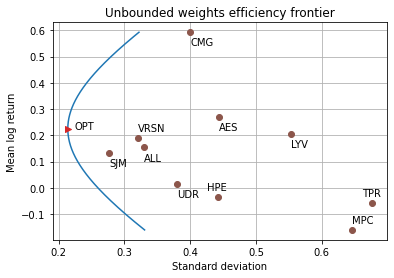

In [21]:
fig, ax = plt.subplots()
x, y, w = optimal_portfolio.minimum_variance(False)
ax.scatter(x, y, marker = '>', color = 'C3', zorder = 3);
ax.text(x+0.01, y, 'OPT')
optimal_portfolio.compute_efficiency_frontier(1000, False)
optimal_portfolio.U.plot(ax)
optimal_portfolio.plot_components(ax)
ax.set_title('Unbounded weights efficiency frontier')

print('Weights of portfolio with minimum variance:')
for i in range(len(optimal_portfolio.tickers)):
    print('{:4}    {:>9.6f}'.format(optimal_portfolio.tickers[i], float(w[i])))
print('')
print('Expected log return:    {:.6f}'.format(float(y)))
print('Log standard deviation: {:.6f}'.format(float(x)))

### Non-negative weights

Task:

>Do the same with an additional restriction $w_i \geq 0 $ for all $i \in  \{1, . . . , 10\}$.

We will use the same approach as before with the additional constraint.

Weights of portfolio with minimum variance:
UDR :  0.1020
LYV :  0.0001
ALL :  0.0363
SJM :  0.5258
MPC :  0.0000
VRSN:  0.0928
AES :  0.0002
HPE :  0.0544
TPR :  0.0000
CMG :  0.1884
Expected log return:    0.2043
Log standard deviation: 0.2217


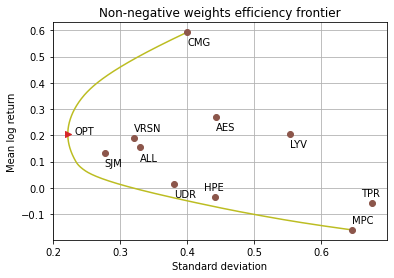

In [22]:
fig, ax = plt.subplots()
x, y, w = optimal_portfolio.minimum_variance(True)
ax.scatter(x, y, marker = '>', color = 'C3', zorder = 3)
ax.text(x+0.01, y, 'OPT')
optimal_portfolio.compute_efficiency_frontier(1000, True)
optimal_portfolio.B.plot(ax)
optimal_portfolio.plot_components(ax)
ax.set_title('Non-negative weights efficiency frontier')

print('Weights of portfolio with minimum variance:')
for i in range(len(optimal_portfolio.tickers)):
    print('{:4}: {:>7.4f}'.format(optimal_portfolio.tickers[i], float(w[i])))
print('Expected log return:    {:.4f}'.format(float(y)))
print('Log standard deviation: {:.4f}'.format(float(x)))

### Random portfolio simulation

We can plot many random portfolios to check that our efficiency frontier is truly the set of the portfolios with minimal variance.

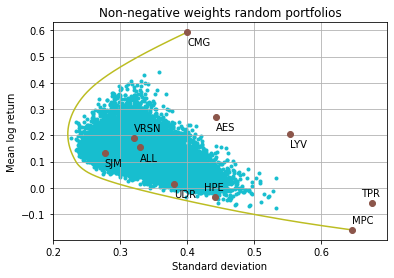

In [23]:
fig, ax = plt.subplots()
optimal_portfolio.random_portfolios(True, n = 20000) # for a nice picture, set n = 60000
optimal_portfolio.rndB.plot(ax)
optimal_portfolio.B.plot(ax)
ax.set_title('Non-negative weights random portfolios')
optimal_portfolio.plot_components(ax)

### Comparison
Finally, we will plot both efficiency frontiers for comparison.

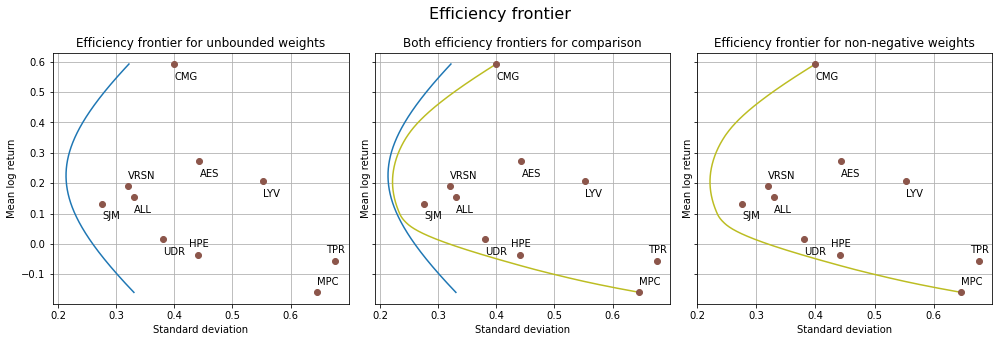

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4.8), sharey=True, tight_layout=True)
fig.suptitle('Efficiency frontier', fontsize=16)


for j in range(3):
    optimal_portfolio.plot_components(ax[j])

optimal_portfolio.U.plot(ax[0])
optimal_portfolio.U.plot(ax[1]) 
optimal_portfolio.B.plot(ax[1]) 
optimal_portfolio.B.plot(ax[2])     


ax[0].set_title('Efficiency frontier for unbounded weights')
ax[1].set_title('Both efficiency frontiers for comparison')
ax[2].set_title('Efficiency frontier for non-negative weights');